In [2]:
from sklearn.preprocessing import MultiLabelBinarizer
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Activation, Embedding, MaxPooling1D, Flatten, GlobalMaxPool1D, Dropout, Conv1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras.callbacks import CSVLogger
from keras.preprocessing.sequence import pad_sequences
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot

In [3]:
# https://stackabuse.com/time-series-analysis-with-lstm-using-pythons-keras-library/
# convert to (records, timesteps, indicators)
def create_window_data_arrays(arrays,window_size):
    data = np.column_stack((arrays))
    arr_len = len(arrays[0])
    windows = np.array([data[i-window_size: i] for i in range(window_size +1,arr_len+1)])
    return windows


def create_window_data_array_with_shift(array,window_size, shift):
    return np.array([array[i-window_size: i] for i in range(shift +1,len(array)+1)])

In [4]:
def example_of_usage():
    future_num_predic_steps = 1
    past_steps_to_use = 4
    arr = np.array([1,2,3,4,5,6,7,8,9,10][:-future_num_predic_steps])
    arr2 = np.array([11, 12, 13, 14,15, 16,17,18,19, 20][:-future_num_predic_steps])
    Y = np.array([111,112, 113, 114,115, 116,117,118,119, 120])


    #Y = np.array([211,212, 213, 214,215, 216,217,218,219, 220])

    X = create_window_data_arrays((arr, arr2), past_steps_to_use)
    Y = create_window_data_array_with_shift(Y,future_num_predic_steps,past_steps_to_use +future_num_predic_steps)
    print(X)
    print(Y)
    print(X.shape)
    print(Y.shape)
example_of_usage()

[[[ 2 12]
  [ 3 13]
  [ 4 14]
  [ 5 15]]

 [[ 3 13]
  [ 4 14]
  [ 5 15]
  [ 6 16]]

 [[ 4 14]
  [ 5 15]
  [ 6 16]
  [ 7 17]]

 [[ 5 15]
  [ 6 16]
  [ 7 17]
  [ 8 18]]

 [[ 6 16]
  [ 7 17]
  [ 8 18]
  [ 9 19]]]
[[116]
 [117]
 [118]
 [119]
 [120]]
(5, 4, 2)
(5, 1)


In [5]:
directory = '../data/'
df_empresas = pd.read_csv(directory + "grouped_data_day_mean_tweets_sentimentdata-scraper_empresas_peru_2019-2020..csv", sep=";", encoding="ISO-8859-1")
df_empresas["normalised_date"]= pd.to_datetime(df_empresas["normalised_date"]) 
df_empresas = df_empresas.rename(columns={"sentiment": "sentiment_empresas"})

df = pd.read_csv(directory + "stocks_and_sentiment_2020.csv", sep=";", names=['date','sentiment','price'], encoding="ISO-8859-1")
df["date"]= pd.to_datetime(df["date"]) 
df = df.rename(columns={"sentiment": "sentiment_asoc"})

df = df_empresas.merge(df, left_on="normalised_date", right_on="date")
df = df[["sentiment_empresas", "sentiment_asoc", "price"]]
df.head()

,sentiment_empresas,sentiment_asoc,price
0,0.243997,0.219692,-0.169729
1,0.185506,0.214739,0.262752
2,0.130081,0.247731,0.298582
3,0.141136,0.232923,0.320586
4,0.156070,0.284574,0.642212


In [6]:
filename_asoc = "../data/grouped_data_day_mean_tweets_sentimentdata-scraper_asociaciones_peru-2016-2020.csv"
filename_empresas ="../data/grouped_data_day_mean_tweets_sentimentdata-scraper_empresas_peru_2017-2020.csv"
filename_precios_bolsa = "../data/pe_bvl_mean_day.csv"

df_asoc = pd.read_csv(filename_asoc, sep=";")
df_empresas = pd.read_csv(filename_empresas, sep=";")
df_precios_bolsa = pd.read_csv(filename_precios_bolsa, sep=";")

df_total = pd.merge(left=df_asoc, right=df_empresas, left_on='normalised_date', right_on='normalised_date')
df_total = df_total.rename(columns={"sentiment_x": "sentiment_asociacones", "sentiment_y": "sentiment_empresas"})
df_total["normalised_date"]= pd.to_datetime(df_total["normalised_date"]) 
df_total = df_total[["normalised_date","sentiment_asociacones", "sentiment_empresas"]]

df_precios_bolsa = df_precios_bolsa[["date", "price_change"]]
df_precios_bolsa["date"]= pd.to_datetime(df_precios_bolsa["date"]) 
df_total = pd.merge(left=df_total, right=df_precios_bolsa, left_on='normalised_date', right_on='date')

df_total.sentiment_asociacones = df_total.sentiment_asociacones.diff()
df_total.sentiment_empresas = df_total.sentiment_empresas.diff()
df_total = df_total.dropna()
df_total = df_total.rename(columns={"price_change": "peru_change"})
df_total['sentiment_asociacones'] = df_total['sentiment_asociacones'].astype(float)
df_total['sentiment_empresas'] = df_total['sentiment_empresas'].astype(float)
df_total['peru_change'] = df_total['peru_change'].astype(float)

# we remove covid months
df_total = df_total[:-80]
df_total

,normalised_date,sentiment_asociacones,sentiment_empresas,date,peru_change
1,2017-03-01,-0.015294,0.105405,2017-03-01,-1.242825
2,2017-03-02,-0.049415,-0.051242,2017-03-02,-0.395745
3,2017-03-03,0.162448,0.090944,2017-03-03,-2.106603
4,2017-03-06,-0.041206,-0.154455,2017-03-06,-0.668194
5,2017-03-07,-0.058503,0.095434,2017-03-07,-0.817405
...,...,...,...,...,...
731,2020-01-28,0.030140,0.097793,2020-01-28,0.021225
732,2020-01-29,-0.000463,0.220291,2020-01-29,-0.833843
733,2020-01-30,-0.077952,-0.389320,2020-01-30,-0.814950
734,2020-01-31,0.123152,0.293223,2020-01-31,-0.057653


In [10]:


from sklearn.preprocessing import MinMaxScaler

#X = scaler.fit_transform(df_diff.values)
#X_sent_asoc = X[:,0][:-future_steps]
#X_prices = X[:,1][:-future_steps]
#X_prices_next = X[:,1]


#plt.plot(X)

num_steps = 15
future_steps = 1

X_sent_asoc = df_total.sentiment_asociacones.values[:-future_steps]
X_sent_empresas = df_total.sentiment_empresas.values[:-future_steps]
X_prices = df_total.peru_change.values[:-future_steps]
X_prices_next = df_total.peru_change.values

'''
scaler = MinMaxScaler(feature_range=(1, 2))
scaler = scaler.fit(df_total[["peru_change", "sentiment_empresas","sentiment_asociacones"]].values.reshape(-1,1))

shape = X_sent_asoc.shape
X_sent_asoc = X_sent_asoc.reshape(-1,1)
X_sent_asoc = scaler.transform(X_sent_asoc)
X_sent_asoc = X_sent_asoc.reshape(shape)

X_sent_empresas = X_sent_empresas.reshape(-1,1)
X_sent_empresas = scaler.transform(X_sent_empresas)
X_sent_empresas = X_sent_empresas.reshape(shape)

X_prices = X_prices.reshape(-1,1)
X_prices = scaler.transform(X_prices)
X_prices = X_prices.reshape(shape)

shape = X_prices_next.shape
X_prices_next = X_prices_next.reshape(-1,1)
X_prices_next = scaler.transform(X_prices_next)
X_prices_next = X_prices_next.reshape(shape)
'''

X = np.array(create_window_data_arrays((X_sent_asoc,X_sent_empresas, X_prices), num_steps))
Y = create_window_data_array_with_shift(X_prices_next, future_steps, num_steps +future_steps)
print(X.shape, Y.shape)

(719, 15, 3) (719, 1)


In [11]:

train_X, test_X, train_y, test_y = train_test_split(
X, Y, test_size=0.10, shuffle=False)

'''
train_X, test_X, train_y, test_y = train_test_split(
X, Y, test_size=0.10, random_state=1000)
'''


print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print(train_y[-10:])

(647, 15, 3) (647, 1) (72, 15, 3) (72, 1)
[[-0.47493182]
 [ 0.28370707]
 [ 1.44782357]
 [ 0.42011665]
 [-0.29527315]
 [-0.05359624]
 [-0.06047858]
 [ 0.91869198]
 [-0.61967774]
 [ 0.61872651]]


Epoch 1/150
17/17 - 0s - loss: 0.5709 - accuracy: 0.0000e+00 - val_loss: 0.5128 - val_accuracy: 0.0000e+00
Epoch 2/150
17/17 - 0s - loss: 0.5708 - accuracy: 0.0000e+00 - val_loss: 0.5118 - val_accuracy: 0.0000e+00
Epoch 3/150
17/17 - 0s - loss: 0.5656 - accuracy: 0.0000e+00 - val_loss: 0.5123 - val_accuracy: 0.0000e+00
Epoch 4/150
17/17 - 0s - loss: 0.5677 - accuracy: 0.0000e+00 - val_loss: 0.5124 - val_accuracy: 0.0000e+00
Epoch 5/150
17/17 - 0s - loss: 0.5663 - accuracy: 0.0000e+00 - val_loss: 0.5128 - val_accuracy: 0.0000e+00
Epoch 6/150
17/17 - 0s - loss: 0.5703 - accuracy: 0.0000e+00 - val_loss: 0.5122 - val_accuracy: 0.0000e+00
Epoch 7/150
17/17 - 0s - loss: 0.5612 - accuracy: 0.0000e+00 - val_loss: 0.5118 - val_accuracy: 0.0000e+00
Epoch 8/150
17/17 - 0s - loss: 0.5686 - accuracy: 0.0000e+00 - val_loss: 0.5116 - val_accuracy: 0.0000e+00
Epoch 9/150
17/17 - 0s - loss: 0.5708 - accuracy: 0.0000e+00 - val_loss: 0.5117 - val_accuracy: 0.0000e+00
Epoch 10/150
17/17 - 0s - loss: 0.565

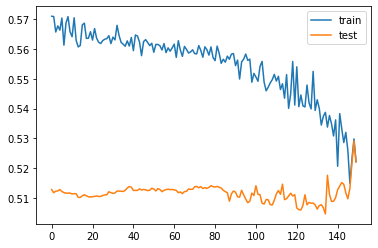

In [18]:
output_size = future_steps
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.4))
model.add(Dense(40, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(output_size))

model.compile(loss='mae', optimizer='adam',metrics=['accuracy'])
csv_logger = CSVLogger('log_loss.csv', append=False, separator=';')
# fit network
history = model.fit(train_X, train_y, epochs=150, batch_size=40, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks=[csv_logger])
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Epoch 1/100
17/17 - 0s - loss: 0.6075 - accuracy: 0.0000e+00 - mae: 0.6075 - val_loss: 0.5189 - val_accuracy: 0.0000e+00 - val_mae: 0.5189
Epoch 2/100
17/17 - 0s - loss: 0.5812 - accuracy: 0.0000e+00 - mae: 0.5812 - val_loss: 0.5177 - val_accuracy: 0.0000e+00 - val_mae: 0.5177
Epoch 3/100
17/17 - 0s - loss: 0.5669 - accuracy: 0.0000e+00 - mae: 0.5669 - val_loss: 0.5141 - val_accuracy: 0.0000e+00 - val_mae: 0.5141
Epoch 4/100
17/17 - 0s - loss: 0.5677 - accuracy: 0.0000e+00 - mae: 0.5677 - val_loss: 0.5147 - val_accuracy: 0.0000e+00 - val_mae: 0.5147
Epoch 5/100
17/17 - 0s - loss: 0.5668 - accuracy: 0.0000e+00 - mae: 0.5668 - val_loss: 0.5168 - val_accuracy: 0.0000e+00 - val_mae: 0.5168
Epoch 6/100
17/17 - 0s - loss: 0.5678 - accuracy: 0.0000e+00 - mae: 0.5678 - val_loss: 0.5153 - val_accuracy: 0.0000e+00 - val_mae: 0.5153
Epoch 7/100
17/17 - 0s - loss: 0.5658 - accuracy: 0.0000e+00 - mae: 0.5658 - val_loss: 0.5137 - val_accuracy: 0.0000e+00 - val_mae: 0.5137
Epoch 8/100
17/17 - 0s - lo

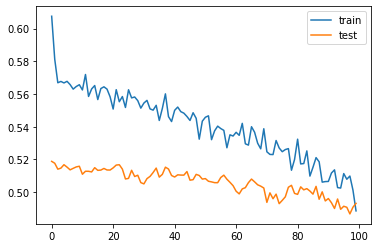

In [21]:
output_size = future_steps
n_timesteps = train_X.shape[1]
n_features = train_X.shape[2]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(output_size))
model.compile(loss='mae', optimizer='adam', metrics=['accuracy', 'mae'])
csv_logger = CSVLogger('log_loss.csv', append=False, separator=';')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=40, validation_data=(test_X, test_y), verbose=2,  callbacks=[csv_logger])
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

2/2 [==============================] - 0s 844us/step
0.49319789121888874
[[ 5.18235429e-01  1.16679192e-01]
 [ 3.53499109e-01  1.80089846e-04]
 [-3.42126755e-01 -5.51631600e-02]
 [ 6.45041774e-01 -1.36332270e-02]
 [ 6.07017374e-01  2.39904821e-01]
 [-2.94287418e-01  3.64676178e-01]
 [ 1.04577768e+00  2.21055120e-01]
 [ 1.07703508e+00 -3.10890712e-02]
 [ 5.11625778e-02 -2.28991779e-03]
 [-2.92885158e-01  8.85261297e-02]
 [ 4.64033355e-01  5.23644686e-02]
 [-1.78072006e+00  6.05429597e-02]
 [-7.30236595e-01  7.19431266e-02]
 [-4.94106493e-01 -2.26797201e-02]
 [-4.83211365e-01 -2.87784815e-01]
 [-7.47248049e-01 -2.77600795e-01]
 [ 1.36121213e+00 -7.28782937e-02]
 [-2.08701476e-02 -1.20397806e-01]
 [-2.58102328e-01 -2.72347406e-02]
 [-3.25615388e-01  1.57251179e-01]
 [ 6.05655440e-01  3.33113670e-01]
 [ 1.37116705e-01  1.83517575e-01]
 [ 5.06297234e-01 -1.53478071e-01]
 [ 1.40011454e-01 -8.02589655e-02]
 [-3.30277054e-01 -5.38271591e-02]
 [ 6.1828000

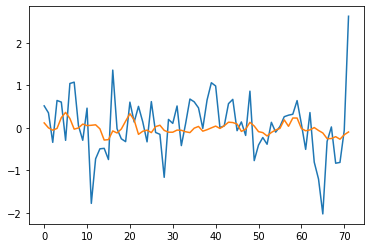

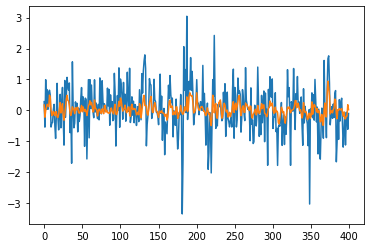

In [22]:
#https://datascience.stackexchange.com/a/45172
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

y_pred = model.predict(test_X, batch_size=40, verbose=1)
print(mean_absolute_error(test_y, y_pred))

M = np.column_stack((test_y, y_pred))
#M_untransformed = scaler.inverse_transform(M)

#y_pred_un = scaler.inverse_transform(y_pred.reshape((len(y_pred),1)))
#test_y_un = scaler.inverse_transform(test_y.reshape((len(test_y),1)))

print(M)


print("---")
#print(M_untransformed)

#print(df_total.values[-3:])


def mean_absolute_percentage_error(y_true, y_pred): 

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

y_pred = model.predict(X, batch_size=40, verbose=1)

print("---")

print(mean_absolute_error(Y, y_pred))
print("---")
print("---")


print(r2_score(y_pred,Y))
print(mean_absolute_percentage_error(y_pred,Y))


y_pred_test = model.predict(test_X, batch_size=40, verbose=1)
print(mean_absolute_error(test_y, y_pred_test))
print(r2_score(y_pred_test,test_y))
print(mean_absolute_percentage_error(y_pred_test,test_y))

M = np.column_stack((test_y, y_pred_test))
plot1 = plt.figure(2)
plt.plot(M)

y_pred_train = model.predict(train_X, batch_size=40, verbose=1)
print(mean_absolute_error(train_y, y_pred_train))
print(r2_score(y_pred_train,train_y))

M = np.column_stack((train_y, y_pred_train))

plot1 = plt.figure(3)
plt.plot(M[:400])

plt.show()


In [28]:
def take_predecesor(y):
    y_pred = y[:-1]
    y_pred = np.insert(y_pred, 0, 0, axis=0)
    return y_pred

Y_null_model = take_predecesor(Y)

M=np.column_stack((Y, Y_null_model))
print(M[:10])

print(mean_absolute_error(Y, Y_null_model))
print(r2_score(Y_null_model,Y))
print(mean_absolute_percentage_error(Y_null_model,Y))


[[-1.79543958  0.        ]
 [ 2.25488958 -1.79543958]
 [ 1.65729523  2.25488958]
 [ 0.29283388  1.65729523]
 [ 0.20167447  0.29283388]
 [-0.58933112  0.20167447]
 [-0.15698911 -0.58933112]
 [ 0.44178488 -0.15698911]
 [ 0.28082861  0.44178488]
 [-0.54325689  0.28082861]]
0.7790496925547731
-0.7349245538884233
inf


/Users/hugojosebello/.local/share/virtualenvs/twitter-data-scripts-analysis-AIss9UM-/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide


In [29]:
predecesor_1 = take_predecesor(Y)
predecesor_2 = take_predecesor(predecesor_1)

Y_null_model = (predecesor_1 + predecesor_2)/2

M=np.column_stack((Y, Y_null_model))
print(M[:10])

print(mean_absolute_error(Y, Y_null_model))
print(r2_score(Y_null_model,Y))
print(mean_absolute_percentage_error(Y_null_model,Y))

[[-1.79543958  0.        ]
 [ 2.25488958 -0.89771979]
 [ 1.65729523  0.229725  ]
 [ 0.29283388  1.9560924 ]
 [ 0.20167447  0.97506455]
 [-0.58933112  0.24725417]
 [-0.15698911 -0.19382833]
 [ 0.44178488 -0.37316012]
 [ 0.28082861  0.14239788]
 [-0.54325689  0.36130674]]
0.6747546950741512
-1.4257203035972248
inf


/Users/hugojosebello/.local/share/virtualenvs/twitter-data-scripts-analysis-AIss9UM-/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide


In [30]:
mean = np.mean(Y)
Y_null_model = np.full(Y.shape, mean)
np.column_stack((Y, Y_null_model))

M=np.column_stack((Y, Y_null_model))
print(M[:10])

print(mean_absolute_error(Y, Y_null_model))
print(r2_score(Y_null_model,Y))
print(mean_absolute_percentage_error(Y_null_model,Y))

[[-1.79543958  0.04199835]
 [ 2.25488958  0.04199835]
 [ 1.65729523  0.04199835]
 [ 0.29283388  0.04199835]
 [ 0.20167447  0.04199835]
 [-0.58933112  0.04199835]
 [-0.15698911  0.04199835]
 [ 0.44178488  0.04199835]
 [ 0.28082861  0.04199835]
 [-0.54325689  0.04199835]]
0.5680841779618132
-1.190531644575582e+34
1352.6344195106637
